In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Read file as weekly cases
cases = pd.read_csv('../assets/datagov/dengue-cases-count-weekly/weekly-number-of-dengue-and-dengue-haemorrhagic-fever-cases.csv')
#Read file as mss
meteo = pd.read_csv('../assets/mss/mss_data.csv')

Massage meterological data into rainfall and temperatures

In [3]:
#drop column 1
meteo=meteo.iloc[:,1:]
# Convert all columns to lowercase and replace spaces in column names.
meteo.columns = meteo.columns.str.lower().str.replace(' ', '_')
#drop all rows with missing year
meteo.drop(meteo[meteo['year'].isnull()].index, inplace = True)
#get week number
meteo['date']=pd.to_datetime(meteo[['year', 'month', 'day']])
meteo['eweek']=meteo['date'].dt.isocalendar().week

In [4]:
rainfall=meteo.groupby(by=["year","eweek"]).sum()
rainfall=rainfall.reset_index()
rainfall=rainfall[["year","eweek","daily_rainfall_total"]]
rainfall.rename(columns={"daily_rainfall_total":"rainfall_weekly_cum"},inplace=True)

In [5]:
temp=meteo.groupby(by=["year","eweek"]).mean()
temp=temp.reset_index()
temp=temp[["year","eweek","mean_temperature"]]
temp.rename(columns={"mean_temperature":"temperature_weekly_avg"},inplace=True)

Massage dengue cases data

In [6]:
cases = cases.loc[cases['type_dengue'] == "Dengue"]
cases.drop(columns={"type_dengue"},inplace=True,errors="ignore")
cases.rename(columns={'number':'dengue_case_count'},inplace=True)

Combine DF including dengue cases and temp/rainfall and shift them by lag period.

In [7]:
df=cases.sort_values(by=["year","eweek"])
df.reset_index(drop=True,inplace=True)
df.dropna(inplace=True)
df=df.merge(rainfall,on=["year","eweek"],how="left")
df=df.merge(temp,on=["year","eweek"],how="left")

In [8]:
df['rainfall_weekly_cum']=df['rainfall_weekly_cum'].shift(periods=17)
df['temperature_weekly_avg']=df['temperature_weekly_avg'].shift(periods=12)
df.dropna(inplace=True)

In [9]:
mms=MinMaxScaler()

In [10]:
alphas=np.arange(0,1,0.1)

In [16]:
def generate_graph_mvg_avg_cross(d,alpha):
    d['rainfall_weekly_cum']=mms.fit_transform(d[['rainfall_weekly_cum']])
    d['temperature_weekly_avg']=mms.fit_transform(d[['temperature_weekly_avg']])
    d['predict']=alpha*d['temperature_weekly_avg']+(1-alpha)*d['rainfall_weekly_cum']
    d['predict']=mms.fit_transform(d[['predict']])
    d['dengue_case_count']=mms.fit_transform(d[['dengue_case_count']])
    d['SMAs']=d['predict'].rolling(15).mean().shift(periods=-15)
    d['SMAf']=d['predict'].rolling(10).mean().shift(periods=-10)
    d['MAC']=d['SMAs']-d['SMAf']
    d.plot(figsize=(10,7),y=['dengue_case_count','MAC'],title=f"Moving Average Crossover (Alpha: {alpha})")
    plt.axhline(y = 0.0, color = 'r', linestyle = '-')

Iterate through each weightage split between temperature and rainfall

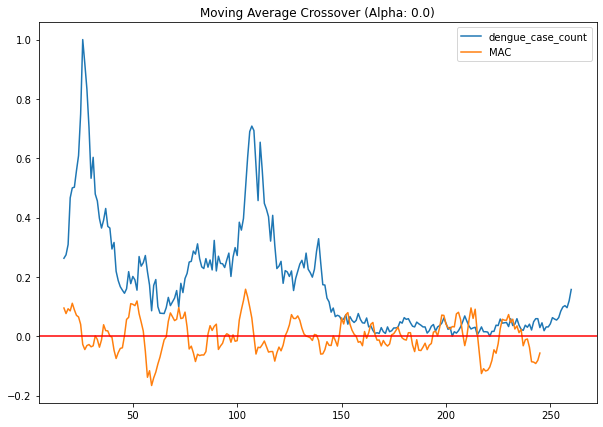

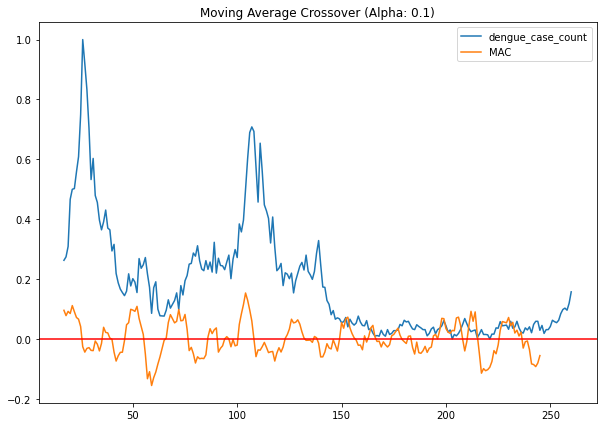

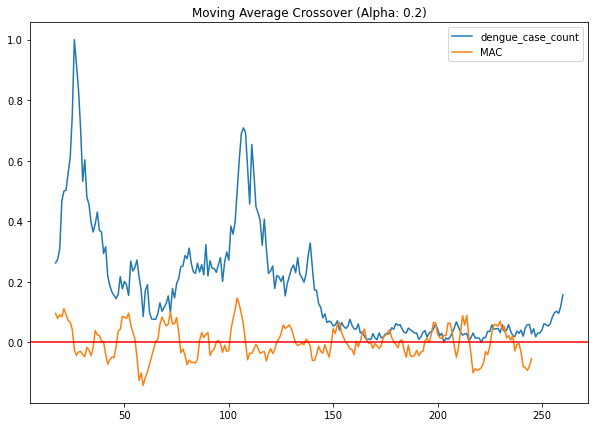

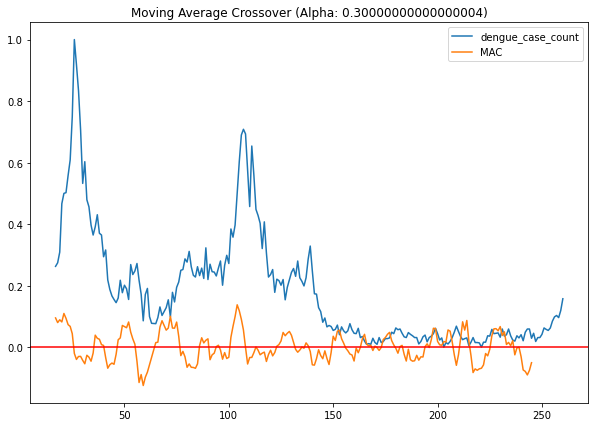

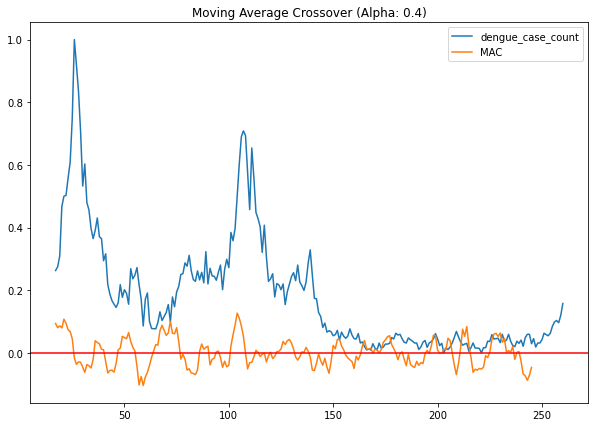

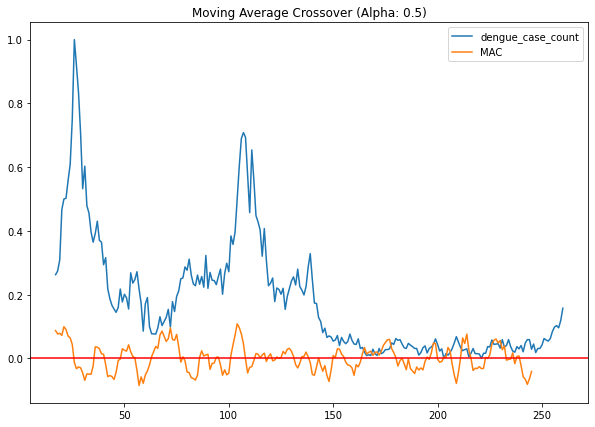

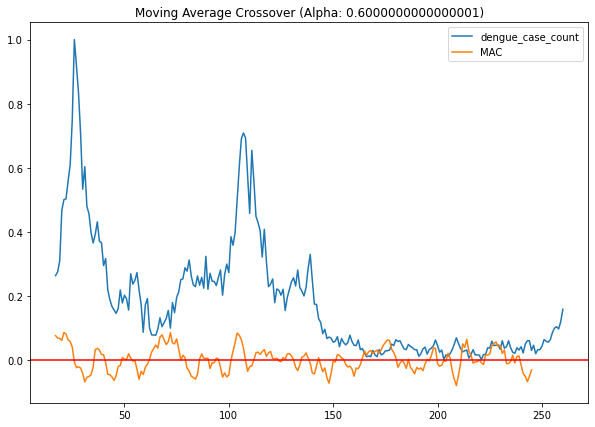

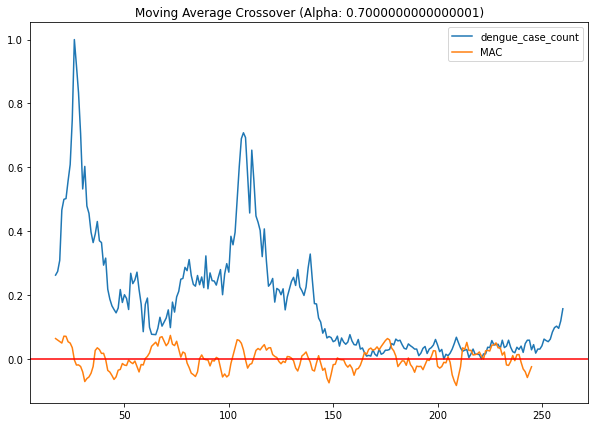

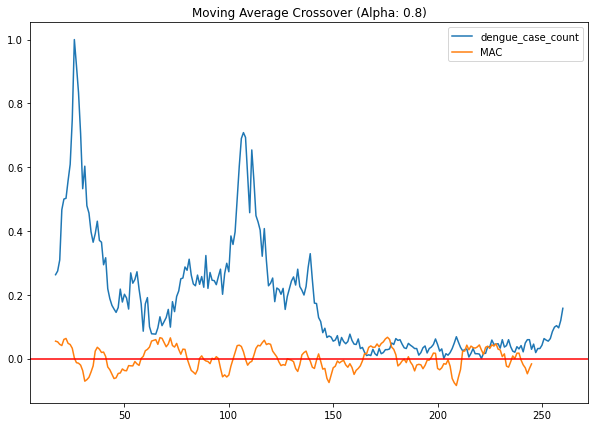

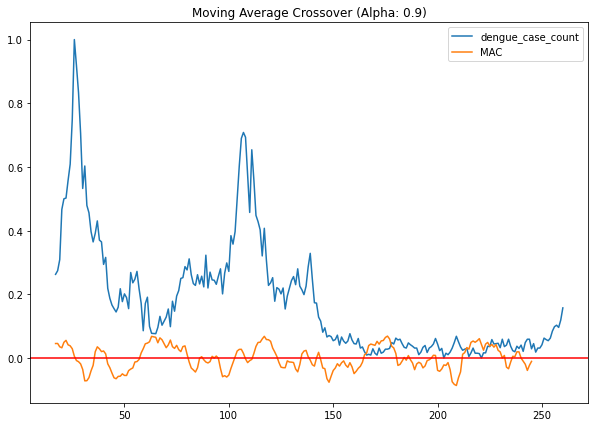

In [17]:
for alpha in alphas:
    generate_graph_mvg_avg_cross(df,alpha)

$\alpha=0.3$ looks the best upon visual check.